In [6]:
from mylib import read_vectors, plot_confidence_interval
import matplotlib.pyplot as plt
import numpy as np
import itertools as it

In [2]:
BASE_DIR = "../simulations/results/"
# **.spawner.tl = exponential(${6..14 step 4}min)
# **.spawner.to = exponential(${6..14 step 4}min)
# **.spawner.tp = exponential(${60,600,6000}min)
# **.spawner.tn = exponential(30min)
TL = range(6, 14+1, 4)
TO = range(6, 14+1, 4)
TP = [60, 600, 6000]
tn = 30
REP = range(10)

vectors = read_vectors(BASE_DIR + "Warmuptime-{},{},{}-#{}.vec.csv", TL, TO, TP, REP)

In [12]:
def winavg(x, N):
    xpad = np.concatenate((np.zeros(N), x)) # pad with zeroes
    s = np.cumsum(xpad)
    ss = s[N:] - s[:-N]
    ss[N-1:] /= N
    ss[:N-1] /= np.arange(1, min(N-1,ss.size)+1)
    return ss

In [3]:
def winavg2(ts, xs, W, dx):
    """ Compute sliding window average over unevenly samples time series

    :param ts: ordered list of timestamps
    :param xs: list of measurements at given timestamp
    :param W: window size
    :param dx: increment between two window averages

	

    xs = 1 2 3 2 4
    ts = 0 1 4 5 7

    . . . . . . . x
    . . . . x . . x
    . x x x x x x x
    x x x x x x x x

    0 1 2 3 4 5 6 7
      ^   ^
      |   wh = i*dx
      wl = wh - W
	
    Compute average in the range wl,wh for i from 0 to max(ts) with increments of dx,
    if wl < min(ts) then wl = min(ts)
    """
    rxs = []

    for wh in np.arange(ts[1], ts[-1], dx):
        wl = max(wh - W, ts[0])

        if wl < ts[0]:
            rxs.append(0)
            continue
       
        i = np.searchsorted(ts, wh, side="rigth") - 1
        # sum to the rigth
        winsum = xs[i] * (wh - ts[i])
        # sum to the left
        j = i-1
        while ts[j] > wl:
            winsum += xs[j] * (ts[j+1] - ts[j])
            j -= 1
        winsum += xs[j] * (ts[j+1] - wl)

        rxs.append(winsum / (wh-wl))
    return np.arange(ts[1], ts[-1], dx), np.asarray(rxs)




In [4]:

def winavg3(ts, xs, W, dx):
    rxs = []

    for wh in np.arange(0, ts[-1], dx):
        wl = wh - W

        if wl < ts[0]:
            rxs.append(0)
            continue
       
        i = np.searchsorted(ts, wh, side="rigth") - 1
        # sum to the rigth
        winsum = xs[i]
        # sum to the left
        j = i-1
        while ts[j] > wl:
            winsum += xs[j]
            j -= 1
        winsum += xs[j]

        rxs.append(winsum / W)
    return np.arange(0, ts[-1], dx), np.asarray(rxs)




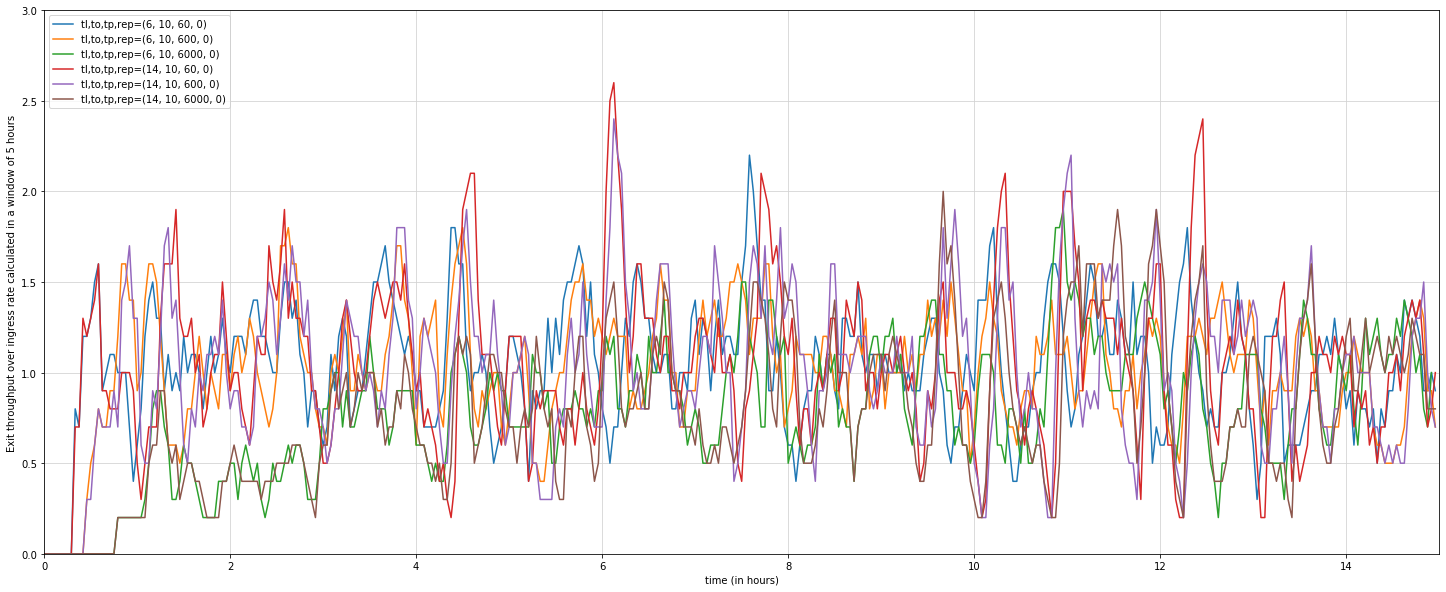

In [10]:

# TL = range(5, 16, 5)
# TO = range(5, 16, 5)
# TP = range(30, 91, 30)
lTL = [6, 14]
lTO = [10]
lTP = TP
lREP = [0]
wsize = 5

plt.rcParams["figure.figsize"] = (25,10)
for par in it.product(lTL, lTO, lTP, lREP):
	vectime, vecvalue = vectors["planeExited"][par]
	ts, xs = winavg3(vectime / (60*60), vecvalue, wsize, 1)
	plt.plot(ts/24, xs*tn/60, label=f"tl,to,tp,rep={par}")
	plt.legend(loc="upper left")
# plt.title(f"planeExitedTroughput with window of {wsize} hours with tn={tn}")
plt.grid(color="lightgray")
plt.xlim((0, 15))
plt.ylim((0, 3))
plt.ylabel(f"Exit throughput over ingress rate calculated in a window of {wsize} hours")
plt.xlabel("time (in hours)")
plt.show()